In [1]:
import numpy as np
import pandas as pd
from numpy.fft import fft, ifft, fftshift, fftfreq, rfft
import matplotlib.pyplot as plt
from matplotlib import cm
import colorcet as cc
import concurrent.futures

#This are my libraries
import snow.nlo as nlo 
import snow.pulses as pulses
import snow.waveguides as waveguides
import snow.opos as opos
import snow.util as util
import snow.materials as materials

#Larger font for plots
plt.rcParams.update({'font.size': 18})

from scipy.constants import pi, c, epsilon_0, h
hplanck = h
pm = 1e-12
nm = 1e-9
um = 1e-6
mm = 1e-3
ns = 1e-9
ps = 1e-12
fs = 1e-15
MHz = 1e6
GHz = 1e9
THz = 1e12
pJ = 1e-12
fJ = 1e-15
mW = 1e-3
uW = 1e-6
nW = 1e-9

## Time and Frequency domain windows

In [2]:
#Let's set the bandwdith
λ_start = 350*nm
λ_stop = 5*um
f_max = c/λ_start
f_min = c/λ_stop
BW = f_max - f_min

N = 2**11 #I usually pick this one to be a power of 2 but that's not strictly necessary

T = N/BW #Time window size
Δt = 1/BW #Time resolution
t_start = -T/2 #Start of time window
#These are the time and frequency vectors 
t = t_start + np.arange(0, T, step=Δt)
f = fftfreq(N, Δt)
Δf = f[1] - f[0]

f_ref = (f_max + f_min)/2  #This variable will be supplied to several plotting functions
λ_ref = c/f_ref
f_ref = round(f_ref/Δf) * Δf
f_abs = f + f_ref #This is the absolute frequency vector
λ = c/f_abs #This is the wavelength vector

print('Time window size = %0.3f ps' %(T/ps))
print((3*f_max - f_min)/BW) #Try to keep it below 4


λ1 = 1.045*um # SH wavelength
f1 = c/λ1 # SH frequency
f2 = 1/2*f1 # Fundamental frequency
λ2 = c/f2 # Fundamental wavelength

Time window size = 2.571 ps
3.150537634408602


## Waveguide properties

Refractive index at pump = 2.057
Refractive index at signal = 1.854
Poling period for second harmonic generation = 5.1557 um
GVM between 2090.0 nm and 1045.0 nm = 1.3097 fs/mm
GVD at 1045.0 nm = 119.6 fs^2/mm
GVD at 2090.0 nm = 22.3 fs^2/mm


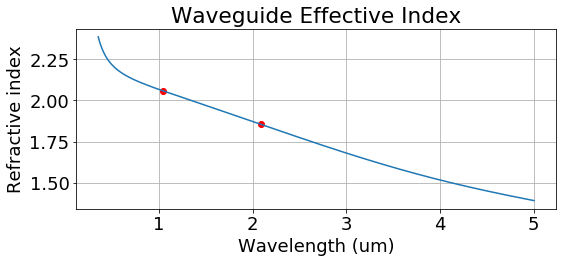

In [100]:
width = 1800*nm
hLN = 700*nm
hetch = 370*nm
wg = waveguides.waveguide(w_top=width, h_thinfilm=hLN, h_etch=hetch, tf_material = 'LN_MgO_e_T',
                         box_material = 'SiO2',  clad_material = 'Air')

T = 25

n = wg.neff(λ, T=T ) #This calculates the refractive index at all wavelengths
n1 = wg.neff( λ1, T=T )
n2 = wg.neff( λ2, T=T )

fig, ax1 = plt.subplots(figsize=(8,4), tight_layout=True)
ax1.plot(fftshift(λ/um), fftshift(n))
ax1.scatter( λ1/um, n1, c='r')
ax1.scatter( λ2/um, n2, c='r')
ax1.set_xlabel('Wavelength (um)')
ax1.set_ylabel('Refractive index')
ax1.set_title('Waveguide Effective Index')
ax1.grid(True)

print('Refractive index at pump = %0.3f' %(n1))
print('Refractive index at signal = %0.3f' %(n2))

pp_shg = 1/(n1/λ1 - 2*n2/λ2)
print("Poling period for second harmonic generation = %0.4f um" %(pp_shg/um))

gvm_ps = wg.beta1(λ1) - wg.beta1(λ2)
print('GVM between %0.1f nm and %0.1f nm = %0.4f fs/mm' %(λ2/nm, λ1/nm, gvm_ps/(fs/mm)) ) 

gvd_1 = wg.GVD(λ1)
gvd_2 = wg.GVD(λ2)
print('GVD at %0.1f nm = %0.1f fs^2/mm' %(λ1/nm, gvd_1/(fs**2/mm) ) )
print('GVD at %0.1f nm = %0.1f fs^2/mm' %(λ2/nm, gvd_2/(fs**2/mm) ) )

## <span style="color: red;">Parameters to vary</span>

In [101]:
# (1) Length of the poling region can be varied from ~2 mm to ~15 mm
#L_array = np.linspace(2,15,10)*mm
L_array = np.linspace(2,15,2)*mm

# (2) Poling period mismatch can be varied from ~-50 nm to 50 nm
#pp_mismatch_array = np.linspace(-50,50,10)*nm
pp_mismatch_array = np.linspace(-50,50,2)*nm

# (3) Pulse energy parameter can be varied from few fJ to few 1000s of fJ
# We can first start from lower energies
#pump_energy_array = np.linspace(5,1000,10)*fJ
pump_energy_array = np.linspace(5,1000,2)*fJ

## Simulation Loops

In [ ]:
# initialize a list to store all rows of data
data = np.empty([len(L_array)*len(pp_mismatch_array)*len(pump_energy_array),2*N+3],dtype=np.complex64)

# define number of available threads:
numthreads = 4

def shg_iters(data,pp_mismatch_array,L_array,pump_energy_array,wg,t,f_ref,f2,kk,jj,qq):
    
    pp_mismatch = pp_mismatch_array[qq]
    L = L_array[kk]
    E2 = pump_energy_array[jj]
    
    # =======================================================================
    # ======== Length, nonlinear coefficients, loss, poling =================
    # =======================================================================
                                                                                  
    #L = 5*mm # ******parameter to vary ~2 to 15 mm******
    #pp_mismatch = 0*nm # ******parameter to vary ~ -50 to 50 nm******
                                                                                                
    pp = pp_shg  + pp_mismatch

    def poling_func(z):
        return np.sign( np.sin(z*2*pi/pp) )

    Alpha = 0.1 # attentuation coefficient (dB/cm)
    alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

    X0 = 1.1e-12 * 0.75

    wg.add_poling(poling_func)
    wg.set_nonlinear_coeffs(N = 1,  X0=X0)
    wg.set_length(L)
    wg.set_loss(alpha)


    # =======================================================================
    # ========================== Input Pulse ================================
    # =======================================================================
    #E2 = 5*fJ # pump energy ******parameter to vary ~fJ to few pJ******

    τ2 = 35*fs # pump pulse width

    frep = 250*MHz #Repetition rate
    N_dB = 100 #Noise level (relative to the pulse peak)

    a2 = pulses.sech_pulse(t, τ2, Energy=E2, f_ref=f_ref, f0=f2, Npwr_dB=N_dB, frep=frep) # pump pulse

    # check to make sure signal and pump are both well contained in the frequency window

    # pump
    #fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
    #ax1 = a2.plot_magsq(ax=ax1, t_unit='ps')
    #ax2 = a2.plot_spectrum(ax=ax2, f_unit='nm')


    # ===================================================================  ======
    # ====================== Single Pass ======================================
    # =========================================================================
    Tsim = 25
    v_ref = 1/wg.beta1(λ2, T=Tsim)
    a_in = a2

    [a_out, evol_steps] = wg.propagate_NEE(a_in, Kg=0, v_ref=v_ref, zcheck_step = 1*mm, T=Tsim) # ******a_out is output data******

    print('Input pulse energy = %0.3f pJ' %(a_in.energy_td()/pJ))
    print('Output pulse energy = %0.3f pJ' %(a_out.energy_td()/pJ))

    a_out.plot_magsq()
    a_out.plot_spectrum()

    # =========================================================================
    # ====================== Save Data in .csv ================================
    # =========================================================================
    # Select output data for saving
            
    # wavelength_axis = c/a_out.f_abs/um  # Wavelength axis in micrometer (um)
    # spectral_power_spectrum = a_out.spectrum(a_out.df)  # power spectrum in dBm in wavelength axis
    time_axis = a_out.t/ps  # Time axis in picoseconds (ps)
    output_field = a_out.a  # output pulse
    input_field = a2.a  # input pulse
            
    # updating input parameters
    poling_region_length = np.array(L/mm,dtype=np.complex64)
    poling_period_mismatch = np.array(pp_mismatch/nm,dtype=np.complex64)
    pump_energy = np.array(E2/fJ,dtype=np.complex64)
    
    nt = len(output_field)
    
    # add values to the data array
    data[kk*len(pp_mismatch_array)*len(pump_energy_array)+jj*len(pump_energy_array)+qq,0] = poling_region_length;
    data[kk*len(pp_mismatch_array)*len(pump_energy_array)+jj*len(pump_energy_array)+qq,1] = poling_period_mismatch;
    data[kk*len(pp_mismatch_array)*len(pump_energy_array)+jj*len(pump_energy_array)+qq,2] = pump_energy;
    data[kk*len(pp_mismatch_array)*len(pump_energy_array)+jj*len(pump_energy_array)+qq,3:(nt+3)] = input_field;
    data[kk*len(pp_mismatch_array)*len(pump_energy_array)+jj*len(pump_energy_array)+qq,(nt+4):] = output_field;
    

with concurrent.futures.ThreadPoolExecutor(max_workers=numthreads) as executor:
    future = [executor.submit(shg_iters,data,pp_mismatch_array,L_array,pump_energy_array,wg,t,f_ref,f2,kk,jj,qq) for kk in range(len(L_array)) for jj in range(len(pp_mismatch_array)) for qq in range(len(pump_energy_array))]
                                                                                                
# Define the column headers

columns = ['Poling Region Length (mm)', 'Poling Period Mismatch (nm)', 'Pump Energy (fJ)'] + [f'Input_{i}' for i in range(N)] + [f'Output_{i}' for i in range(N)]

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=columns)

# Save the DataFrame to a CSV file
csv_file_path = 'SHG_output.csv'
df.to_csv(csv_file_path, index=False)

print(f"Data saved to {csv_file_path}")

finished
Total time = 6.8 s
Input pulse energy = 0.005 pJ
Output pulse energy = 0.005 pJ
finished
Total time = 6.5 s
Input pulse energy = 0.005 pJ
Output pulse energy = 0.005 pJ
